# Alabama 2020 Flip Markov Chain Simulation
#### Authors: Khaleefa AlHemeiri and Ethan Tu

### Importing Necessary Libraries

The first step is to import all the required libraries for working with graphs, handling GeoDataFrames, and running the GerryChain Markov Chain process. We also import plotting libraries to visualize the results.


In [1]:
# For working with graphs
import networkx as nx
# For making plots
import matplotlib.pyplot as plt
import numpy as np

# Needed for gerrychain
import gerrychain
from gerrychain import Graph, Partition, proposals, updaters, constraints, accept, MarkovChain, GeographicPartition
from gerrychain.updaters import Tally, cut_edges
from gerrychain.tree import recursive_tree_part
from gerrychain.proposals import propose_random_flip
from gerrychain.accept import always_accept
from gerrychain.constraints import within_percent_of_ideal_population
from functools import partial
import geopandas as gpd
import pandas as pd

# For creating the graph from the shapefile
import maup
from geopandas import GeoSeries, GeoDataFrame
from tqdm import tqdm

# Ensuring that the randomness is controlled
import random
random.seed(123456)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/ethantu/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Loading The Shapefile
Access the repaired precincts shapefile by downloading and unzipping `repaired_data.shp.zip` from the GitHub or running `repair.ipynb` to create it for yourself.

Download the congressional districts shapefile at https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=Congressional+Districts+%28116%29 and unzip it to get `tl_2020_us_cd116.shp`.

In [2]:
# Load precinct shapefile 
precincts_path = "~/Downloads/repaired_data.shp"  # Update the file path to access your repaired_data
precincts = gpd.read_file(precincts_path)

# Load the new congressional districts shapefile
districts_path = "~/Downloads/tl_2020_us_cd116/tl_2020_us_cd116.shp"  # Update the file path if necessary to access the new downloaded shapefile
districts = gpd.read_file(districts_path)

# Filter the districts shapefile for only Alabama (assuming 'STATEFP' is the state FIPS code column)
alabama_districts = districts[districts['STATEFP'] == '01']  # '01' is the FIPS code for Alabama

# Check and print the CRS of both GeoDataFrames
print("Precincts CRS:", precincts.crs)
print("Alabama Districts CRS:", alabama_districts.crs)

# If they have different CRS, align them by converting to a common CRS
if precincts.crs != alabama_districts.crs:
    alabama_districts = alabama_districts.to_crs(precincts.crs)

Precincts CRS: EPSG:3857
Alabama Districts CRS: EPSG:4269


### Preparing Shapefiles for Dual Graph Construction

district
3    400
4    349
5    348
1    272
0    219
2    197
6    187
Name: count, dtype: int64


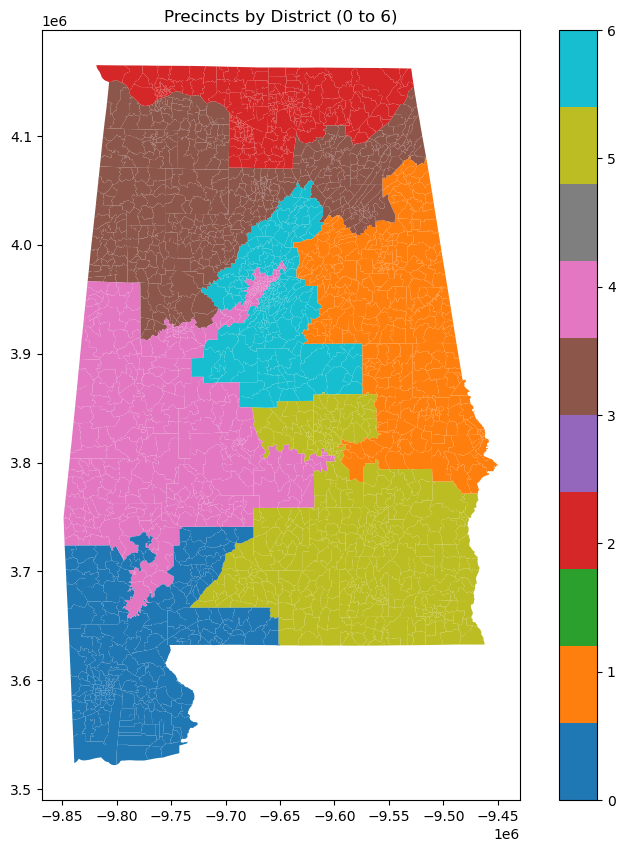

In [3]:
# Assign precincts to districts
assignment = maup.assign(precincts, alabama_districts)
precincts['district'] = assignment

# Map the district numbers to the range [0, 6]
unique_districts = precincts['district'].unique()
district_mapping = {old: new for new, old in enumerate(sorted(unique_districts))}
precincts['district'] = precincts['district'].map(district_mapping)

# Optionally, check the distribution of precincts across districts
print(precincts['district'].value_counts())

# Plot the precincts colored by district
precincts.plot(column='district', figsize=(10, 10), legend=True, cmap="tab10")
plt.title("Precincts by District (0 to 6)")
plt.show()



In [4]:
# Check for NA values
precincts[assignment.isna()]

,GEOID20,STATEFP20,COUNTYFP20,VTDST20,NAME20,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREOWRI,G20USSRTUB,...,G20SACOWR2,G20SCCRWIN,G20SCCOWRI,G20SCCRKEL,G20SCCOWR2,G20PSCRCAV,G20PSCDCAS,G20PSCOWRI,geometry,district


In [5]:
# Ensure the gdfs have no invalids, holes, or overlaps
maup.doctor(alabama_districts)
maup.doctor(precincts)

True

In [6]:
# Add total population column
if "TOT_POP" not in precincts.columns:
    precincts["TOT_POP"] = (
        precincts["G20PRERTRU"] + precincts["G20PREDBID"] + precincts["G20PRELJOR"] + precincts["G20PREOWRI"]
    )

### Creating The Dual Graph

In [7]:
al_graph = Graph.from_geodataframe(precincts)
al_graph

<Graph [1972 nodes, 5649 edges]>

In [8]:
# Ensure the dual graph is connected
print(nx.is_connected(al_graph))

True


### Preparing Variables For Markov Chain Simulation
We will be observing partisan balance using 2020 presidential election data

In [9]:
# Define the number of districts and ideal population
num_dist = 7  # Alabama's number of congressional districts
tot_pop = sum(al_graph.nodes[node]["TOT_POP"] for node in al_graph.nodes)
ideal_pop = tot_pop / num_dist
pop_tolerance = 0.02

In [10]:
#Creating the initial districting plan
initial_plan = recursive_tree_part(
    al_graph, # dual graph
    range(num_dist), 
    ideal_pop, 
    "TOT_POP", 
    pop_tolerance, 
    node_repeats=10, 
)

We need to set up initial state as a *Partition object*<br>
Partition objects include a districting plan and also information about the plan <br>
(we get to specify which information we want to keep track of) <br><br>

To create a Partition object <br>
1st argument: dual graph <br>
2nd argument: initial districting plan <br>
3rd argument: updaters: things we want to calculate for each plan in your random walk. <br>
    We are keeping track of each districts' total population, number of Democratic votes, and number of Republican votes <br>
Format for each: "name_I'm_giving_my_updater: function_for_how_to_calculate_it" <br><br>

In [11]:
plan2020 = GeographicPartition(
    al_graph, # dual graph
    assignment=initial_plan, # initial districting plan
    updaters={
        "population": Tally("TOT_POP", alias="population"),
        "DemocraticVotes": Tally("G20PREDBID", alias="DemocraticVotes"),
        "RepublicanVotes": Tally("G20PRERTRU", alias="RepublicanVotes"),
    },
)

The `enactedplan2020` will be used to calculated the enacted plan's Democrat/Republican values for the boxplots later

In [12]:
# Convert Series to a dictionary
assignment_dict = assignment.to_dict()

# Map the district numbers to the range [0, 6]
unique_districts = list(set(assignment_dict.values()))  # Extract unique district numbers
district_mapping = {old: new for new, old in enumerate(sorted(unique_districts))}  # Map old to new
assignment_dict = {precinct: district_mapping[district] for precinct, district in assignment_dict.items()}

# Create the GeographicPartition
enactedplan2020 = GeographicPartition(
    al_graph,
    assignment=assignment_dict,
    updaters={
        "population": Tally("TOT_POP", alias="population"),
        "DemocraticVotes": Tally("G20PREDBID", alias="DemocraticVotes"),
        "RepublicanVotes": Tally("G20PRERTRU", alias="RepublicanVotes"),
    },
)

# Print to verify
print(enactedplan2020)


<GeographicPartition [7 parts]>


### Defining Parameters For Flip Markov Chain
This is where we specify that we are performing a Flip Markov Chain

In [13]:
# Define Flip proposal
flip_proposal = partial(
    propose_random_flip
)

Contraint on population: stay within pop_tolerance of ideal

In [14]:
# Define population constraint
pop_constraint = within_percent_of_ideal_population(
    plan2020, pop_tolerance)

### Creating The Markov Chain
The following sets up the chain, but doesn't run it!

In [15]:
# Function to run Markov Chain
def run_markov_chain(steps):
    chain = MarkovChain(
        proposal=flip_proposal, 
        constraints=[pop_constraint],
        accept=lambda x: True,
        initial_state=plan2020,
        total_steps=steps,
    )
    democratic_majorities = []
    republican_majorities = []
    
    print(f"Running Markov Chain for {steps} steps...")
    for idx, part in enumerate(chain):
        # Track progress at every 10% or configurable intervals
        if idx % (steps // 10) == 0:  # Adjust frequency as needed
            print(f"Progress: {idx}/{steps} steps completed ({(idx / steps) * 100:.1f}%).")
        
        dem_majority = sum(
            1 for dist in part.parts if part["DemocraticVotes"][dist] > part["RepublicanVotes"][dist]
        )
        rep_majority = num_dist - dem_majority  # Remaining districts are Republican-majority
        democratic_majorities.append(dem_majority)
        republican_majorities.append(rep_majority)

    print(f"Completed Markov Chain for {steps} steps.")
    return democratic_majorities, republican_majorities

### Running The Markov Chain

In [ ]:
# Run Markov Chains for 100,000, 1,000,000, and 10,000,000 steps
dem_majorities_100k, rep_majorities_100k = run_markov_chain(100000)
print()
dem_majorities_1m, rep_majorities_1m = run_markov_chain(1000000)
print()
dem_majorities_10m, rep_majorities_10m = run_markov_chain(10000000)

### Visualizing Markov Chain Results

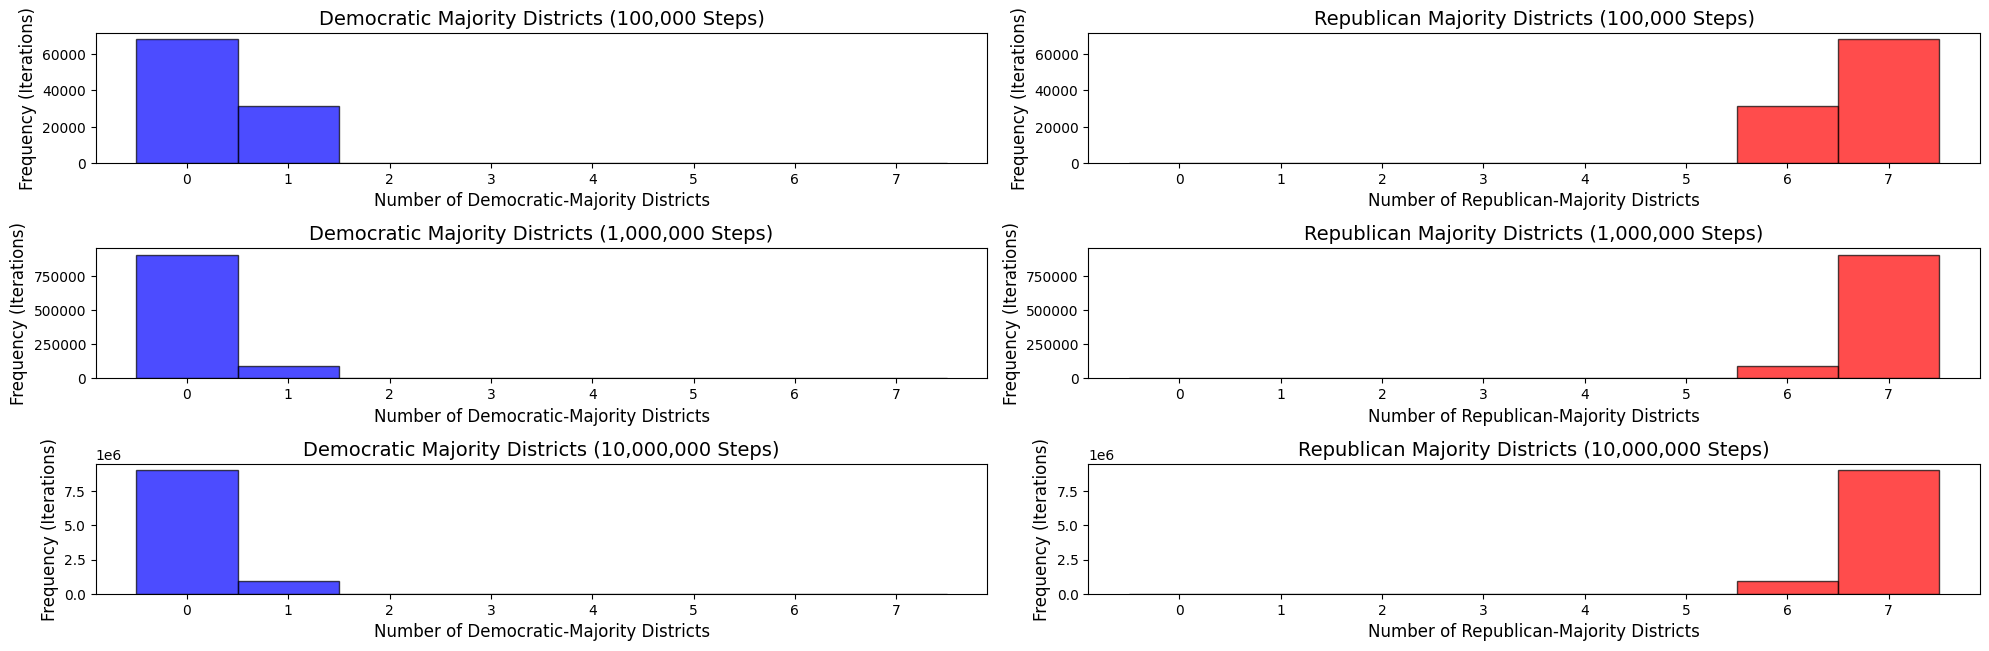

In [19]:
plt.figure(figsize=(20, 15))  # Larger figure size

# Define bins for the histogram (integer values from 0 to num_dist)
bins = np.arange(0, num_dist + 2) - 0.5  # Shifts bin edges to center bars

# Adjust the grid to 7x2 to fit 14 subplots
plt.subplot(7, 2, 9)
plt.hist(dem_majorities_100k, bins=bins, color="blue", alpha=0.7, edgecolor="black")
plt.title("Democratic Majority Districts (100,000 Steps)", fontsize=14)
plt.xlabel("Number of Democratic-Majority Districts", fontsize=12)
plt.ylabel("Frequency (Iterations)", fontsize=12)
plt.xticks(range(0, num_dist + 1))

# Plot Republican-majority for 100,000 steps
plt.subplot(7, 2, 10)
plt.hist(rep_majorities_100k, bins=bins, color="red", alpha=0.7, edgecolor="black")
plt.title("Republican Majority Districts (100,000 Steps)", fontsize=14)
plt.xlabel("Number of Republican-Majority Districts", fontsize=12)
plt.ylabel("Frequency (Iterations)", fontsize=12)
plt.xticks(range(0, num_dist + 1))

# Plot Democratic-majority for 1,000,000 steps
plt.subplot(7, 2, 11)
plt.hist(dem_majorities_1m, bins=bins, color="blue", alpha=0.7, edgecolor="black")
plt.title("Democratic Majority Districts (1,000,000 Steps)", fontsize=14)
plt.xlabel("Number of Democratic-Majority Districts", fontsize=12)
plt.ylabel("Frequency (Iterations)", fontsize=12)
plt.xticks(range(0, num_dist + 1))

# Plot Republican-majority for 1,000,000 steps
plt.subplot(7, 2, 12)
plt.hist(rep_majorities_1m, bins=bins, color="red", alpha=0.7, edgecolor="black")
plt.title("Republican Majority Districts (1,000,000 Steps)", fontsize=14)
plt.xlabel("Number of Republican-Majority Districts", fontsize=12)
plt.ylabel("Frequency (Iterations)", fontsize=12)
plt.xticks(range(0, num_dist + 1))

# Plot Democratic-majority for 10,000,000 steps
plt.subplot(7, 2, 13)
plt.hist(dem_majorities_10m, bins=bins, color="blue", alpha=0.7, edgecolor="black")
plt.title("Democratic Majority Districts (10,000,000 Steps)", fontsize=14)
plt.xlabel("Number of Democratic-Majority Districts", fontsize=12)
plt.ylabel("Frequency (Iterations)", fontsize=12)
plt.xticks(range(0, num_dist + 1))

# Plot Republican-majority for 10,000,000 steps
plt.subplot(7, 2, 14)
plt.hist(rep_majorities_10m, bins=bins, color="red", alpha=0.7, edgecolor="black")
plt.title("Republican Majority Districts (10,000,000 Steps)", fontsize=14)
plt.xlabel("Number of Republican-Majority Districts", fontsize=12)
plt.ylabel("Frequency (Iterations)", fontsize=12)
plt.xticks(range(0, num_dist + 1))

# Apply tight layout
plt.tight_layout()
plt.show()

In [20]:
# Print averages for clarity
print("Average Democratic-Majority Districts (100,000 Steps):", sum(dem_majorities_100k) / len(dem_majorities_100k))
print("Average Republican-Majority Districts (100,000 Steps):", sum(rep_majorities_100k) / len(rep_majorities_100k))

print("Average Democratic-Majority Districts (1,000,000 Steps):", sum(dem_majorities_1m) / len(dem_majorities_1m))
print("Average Republican-Majority Districts (1,000,000 Steps):", sum(rep_majorities_1m) / len(rep_majorities_1m))

print("Average Democratic-Majority Districts (10,000,000 Steps):", sum(dem_majorities_10m) / len(dem_majorities_10m))
print("Average Republican-Majority Districts (10,000,000 Steps):", sum(rep_majorities_10m) / len(rep_majorities_10m))

Average Democratic-Majority Districts (100,000 Steps): 0.31626
Average Republican-Majority Districts (100,000 Steps): 6.68374
Average Democratic-Majority Districts (1,000,000 Steps): 0.092914
Average Republican-Majority Districts (1,000,000 Steps): 6.907086
Average Democratic-Majority Districts (10,000,000 Steps): 0.0955508
Average Republican-Majority Districts (10,000,000 Steps): 6.9044492


### Boxplot Functions For Majority Districts In Alabama By Party Vote

In [17]:
# Function to run Markov Chain and calculate vote percentages
def calculate_vote_percentages(chain):
    vote_percentages = []
    for part in chain:
        district_percentages = []
        for dist in range(num_dist):
            dem_votes = part["DemocraticVotes"][dist]
            rep_votes = part["RepublicanVotes"][dist]
            total_votes = dem_votes + rep_votes
            district_percentages.append(dem_votes / total_votes)  # Democratic % of votes
        vote_percentages.append(sorted(district_percentages))
    return np.array(vote_percentages)

In [18]:
# Calculate enacted values (red dots)
enacted_percentages = []
for dist in range(num_dist):
    dem_votes = enactedplan2020["DemocraticVotes"][dist]
    rep_votes = enactedplan2020["RepublicanVotes"][dist]
    total_votes = dem_votes + rep_votes
    enacted_percentages.append(dem_votes / total_votes)

enacted_percentages.sort()
print(enacted_percentages)

[0.1788619941968152, 0.32518711480346174, 0.3376417781993737, 0.3562420261633408, 0.35970590715383766, 0.3623342515608472, 0.7111485677946978]


### Boxplot For 100,000 Steps

In [19]:
# Markov Chain for 100,000 Steps
print("Calculating vote percentages for 100,000 steps...")
chain_100k = MarkovChain(
    proposal=flip_proposal,
    constraints=[pop_constraint],
    accept=lambda x: True,
    initial_state=plan2020,
    total_steps=100000,
)

dem_vote_percentages_100k = []
rep_vote_percentages_100k = []

# Use tqdm for progress tracking
for part in tqdm(chain_100k, total=100000, desc="Processing 100,000 steps"):
    dem_percentages = []
    rep_percentages = []
    for dist in range(num_dist):
        dem_votes = part["DemocraticVotes"][dist]
        rep_votes = part["RepublicanVotes"][dist]
        total_votes = dem_votes + rep_votes
        dem_percentages.append(dem_votes / total_votes)
        rep_percentages.append(rep_votes / total_votes)
    dem_vote_percentages_100k.append(sorted(dem_percentages))
    rep_vote_percentages_100k.append(sorted(rep_percentages))

Calculating vote percentages for 100,000 steps...


Processing 100,000 steps: 100%|██████████| 100000/100000 [00:13<00:00, 7181.31it/s]


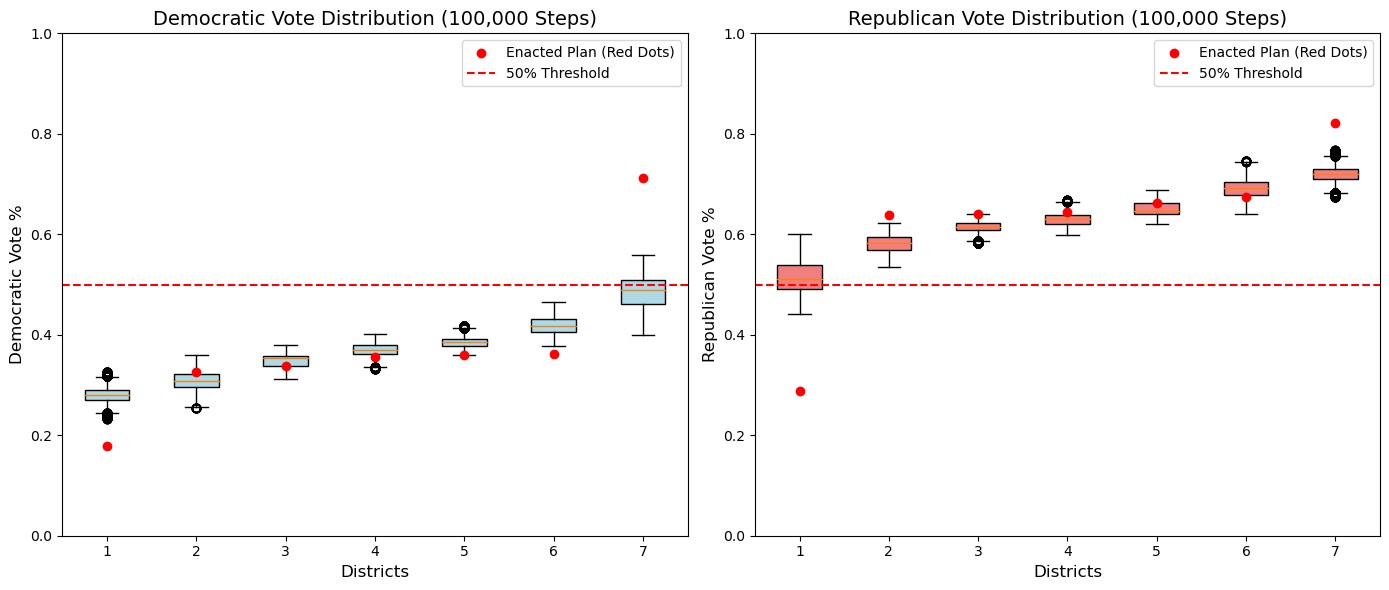

In [21]:
# Convert to NumPy arrays
dem_vote_percentages_100k = np.array(dem_vote_percentages_100k)
rep_vote_percentages_100k = np.array(rep_vote_percentages_100k)

# Plot Box Plots for 100,000 Steps
plt.figure(figsize=(14, 6))

# Democratic Vote Percentages
plt.subplot(1, 2, 1)
plt.boxplot(
    dem_vote_percentages_100k,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue", color="black"),
)
plt.scatter(
    x=np.arange(1, num_dist + 1),
    y=enacted_percentages,
    color="red",
    label="Enacted Plan (Red Dots)",
    zorder=5,
)
plt.axhline(y=0.5, color="red", linestyle="--", linewidth=1.5, label="50% Threshold")
plt.title("Democratic Vote Distribution (100,000 Steps)", fontsize=14)
plt.xlabel("Districts", fontsize=12)
plt.ylabel("Democratic Vote %", fontsize=12)
plt.ylim(0, 1)
plt.legend()

# Republican Vote Percentages
plt.subplot(1, 2, 2)
plt.boxplot(
    rep_vote_percentages_100k,
    patch_artist=True,
    boxprops=dict(facecolor="lightcoral", color="black"),
)
plt.scatter(
    x=np.arange(1, num_dist + 1),
    y=sorted([1 - p for p in enacted_percentages]),  # Republican enacted percentages in ascending order
    color="red",
    label="Enacted Plan (Red Dots)",
    zorder=5,
)
plt.axhline(y=0.5, color="red", linestyle="--", linewidth=1.5, label="50% Threshold")
plt.title("Republican Vote Distribution (100,000 Steps)", fontsize=14)
plt.xlabel("Districts", fontsize=12)
plt.ylabel("Republican Vote %", fontsize=12)
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()

### Boxplot For 1,000,000 Steps

In [25]:
# Markov Chain for 1,000,000 Steps
print("Calculating vote percentages for 1,000,000 steps...")
chain_1m = MarkovChain(
    proposal=flip_proposal,
    constraints=[pop_constraint],
    accept=lambda x: True,
    initial_state=plan2020,
    total_steps=1000000,
)

dem_vote_percentages_1m = []
rep_vote_percentages_1m = []

# Use tqdm for progress tracking
for part in tqdm(chain_1m, total=1000000, desc="Processing 1,000,000 steps"):
    dem_percentages = []
    rep_percentages = []
    for dist in range(num_dist):
        dem_votes = part["DemocraticVotes"][dist]
        rep_votes = part["RepublicanVotes"][dist]
        total_votes = dem_votes + rep_votes
        dem_percentages.append(dem_votes / total_votes)
        rep_percentages.append(rep_votes / total_votes)
    dem_vote_percentages_1m.append(sorted(dem_percentages))
    rep_vote_percentages_1m.append(sorted(rep_percentages))

Calculating vote percentages for 1,000,000 steps...


Processing 1,000,000 steps: 100%|██████████| 1000000/1000000 [02:57<00:00, 5632.77it/s]


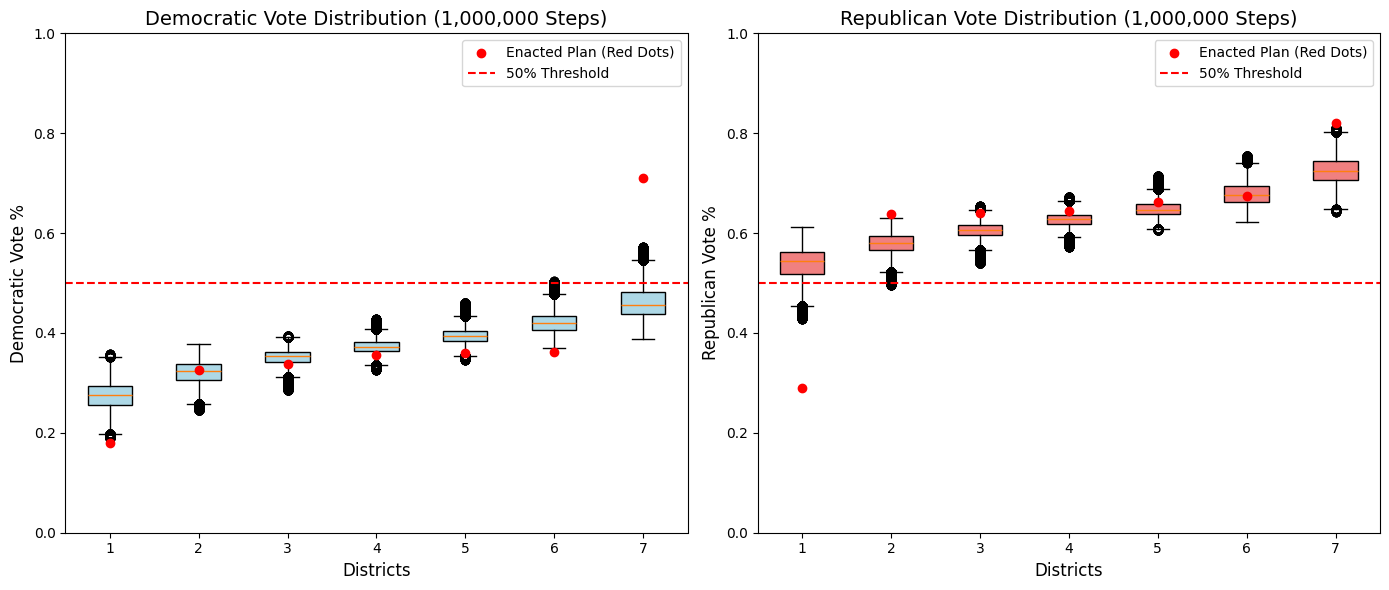

In [26]:
# Convert to NumPy arrays
dem_vote_percentages_1m = np.array(dem_vote_percentages_1m)
rep_vote_percentages_1m = np.array(rep_vote_percentages_1m)

# Plot Box Plots for 1,000,000 Steps
plt.figure(figsize=(14, 6))

# Democratic Vote Percentages
plt.subplot(1, 2, 1)
plt.boxplot(
    dem_vote_percentages_1m,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue", color="black"),
)
plt.scatter(
    x=np.arange(1, num_dist + 1),
    y=enacted_percentages,
    color="red",
    label="Enacted Plan (Red Dots)",
    zorder=5,
)
plt.axhline(y=0.5, color="red", linestyle="--", linewidth=1.5, label="50% Threshold")
plt.title("Democratic Vote Distribution (1,000,000 Steps)", fontsize=14)
plt.xlabel("Districts", fontsize=12)
plt.ylabel("Democratic Vote %", fontsize=12)
plt.ylim(0, 1)
plt.legend()

# Republican Vote Percentages
plt.subplot(1, 2, 2)
plt.boxplot(
    rep_vote_percentages_1m,
    patch_artist=True,
    boxprops=dict(facecolor="lightcoral", color="black"),
)
plt.scatter(
    x=np.arange(1, num_dist + 1),
    y=sorted([1 - p for p in enacted_percentages]),  # Republican enacted percentages in ascending order
    color="red",
    label="Enacted Plan (Red Dots)",
    zorder=5,
)
plt.axhline(y=0.5, color="red", linestyle="--", linewidth=1.5, label="50% Threshold")
plt.title("Republican Vote Distribution (1,000,000 Steps)", fontsize=14)
plt.xlabel("Districts", fontsize=12)
plt.ylabel("Republican Vote %", fontsize=12)
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()

### Boxplot For 10,000,000 Steps

In [18]:
# Markov Chain for 10,000,000 Steps
print("Calculating vote percentages for 10,000,000 steps...")
chain_10m = MarkovChain(
    proposal=flip_proposal,
    constraints=[pop_constraint],
    accept=lambda x: True,
    initial_state=plan2020,
    total_steps=10000000,
)

dem_vote_percentages_10m = []
rep_vote_percentages_10m = []

# Use tqdm for progress tracking
for part in tqdm(chain_10m, total=10000000, desc="Processing 10,000,000 steps"):
    dem_percentages = []
    rep_percentages = []
    for dist in range(num_dist):
        dem_votes = part["DemocraticVotes"][dist]
        rep_votes = part["RepublicanVotes"][dist]
        total_votes = dem_votes + rep_votes
        dem_percentages.append(dem_votes / total_votes)
        rep_percentages.append(rep_votes / total_votes)
    dem_vote_percentages_10m.append(sorted(dem_percentages))
    rep_vote_percentages_10m.append(sorted(rep_percentages))

Calculating vote percentages for 10,000,000 steps...


Processing 10,000,000 steps: 100%|██████████| 10000000/10000000 [28:00<00:00, 5949.12it/s] 


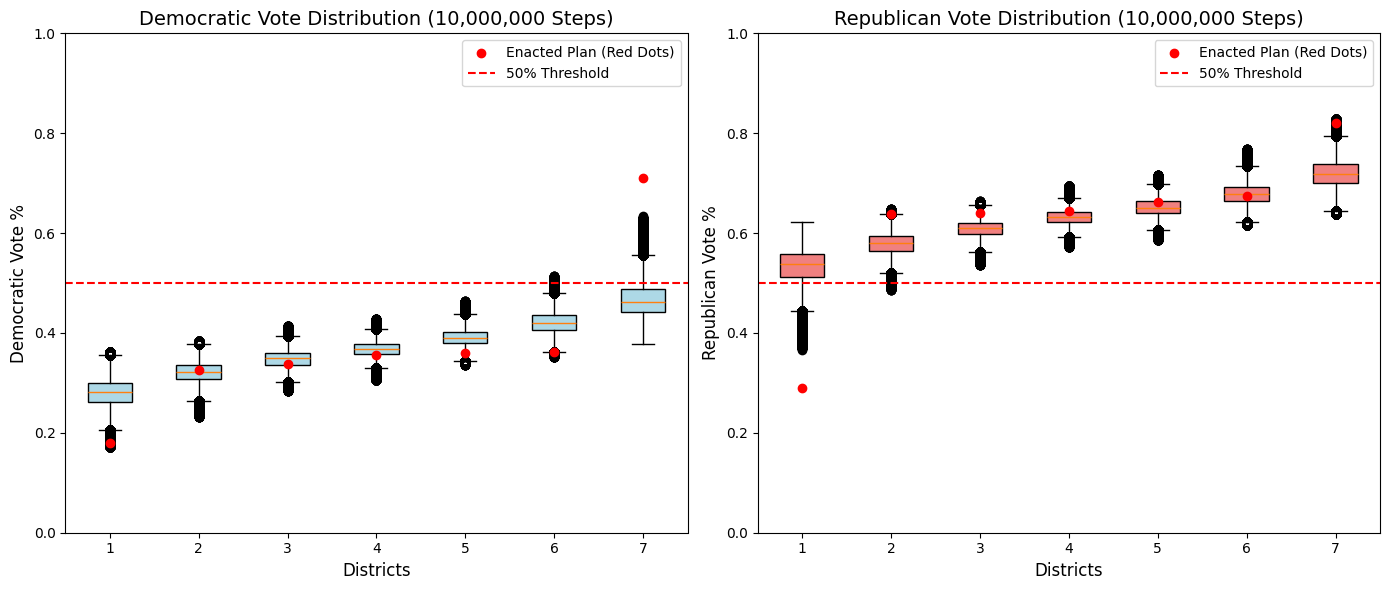

In [ ]:
# Convert to NumPy arrays
dem_vote_percentages_10m = np.array(dem_vote_percentages_10m)
rep_vote_percentages_10m = np.array(rep_vote_percentages_10m)

# Plot Box Plots for 10,000,000 Steps
plt.figure(figsize=(14, 6))

# Democratic Vote Percentages
plt.subplot(1, 2, 1)
plt.boxplot(
    dem_vote_percentages_10m,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue", color="black"),
)
plt.scatter(
    x=np.arange(1, num_dist + 1),
    y=enacted_percentages,
    color="red",
    label="Enacted Plan (Red Dots)",
    zorder=5,
)
plt.axhline(y=0.5, color="red", linestyle="--", linewidth=1.5, label="50% Threshold")
plt.title("Democratic Vote Distribution (10,000,000 Steps)", fontsize=14)
plt.xlabel("Districts", fontsize=12)
plt.ylabel("Democratic Vote %", fontsize=12)
plt.ylim(0, 1)
plt.legend()

# Republican Vote Percentages
plt.subplot(1, 2, 2)
plt.boxplot(
    rep_vote_percentages_10m,
    patch_artist=True,
    boxprops=dict(facecolor="lightcoral", color="black"),
)
plt.scatter(
    x=np.arange(1, num_dist + 1),
    y=sorted([1 - p for p in enacted_percentages]),  # Republican enacted percentages in ascending order
    color="red",
    label="Enacted Plan (Red Dots)",
    zorder=5,
)
plt.axhline(y=0.5, color="red", linestyle="--", linewidth=1.5, label="50% Threshold")
plt.title("Republican Vote Distribution (10,000,000 Steps)", fontsize=14)
plt.xlabel("Districts", fontsize=12)
plt.ylabel("Republican Vote %", fontsize=12)
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()